# Carga de Librerias

In [0]:
from google.colab import files
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display_html
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Algoritmos de predicción
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

# Algoritmos de optimización
from sklearn.model_selection import GridSearchCV


# Metodos




In [0]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [0]:
# Este metodo grafica los datos
def plotdata(_test, _y_pred, title, _mae):
  plt.figure(figsize=(27,8))  
  plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 'vertical')
  plt.grid(True)
  plt.plot(_test.index, _test[input_Col], c='r', label='data')
  plt.plot(_test.index, _y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title(title + " (MAE = %6.3f')" % (_mae))  
  plt.show()

In [0]:
# Grafica un arreglo de modelos
def plotModels(regressors, regr_names):
  results = pd.DataFrame()               
  for i, r in enumerate(regressors):
    r.fit( X = train.drop([input_Col], axis=1), y = train[input_Col])
    y = r.predict(X = test.drop([input_Col], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test[input_Col],y)
    # Plot the results  
    # Selecciono los ultimos 2 meses para la grafica
    test_plot = test.loc['2019-06-01':]  
    y_plot = results[regr_names[i]][-test_plot.shape[0]:]
    plotdata(test_plot,y_plot,regr_names[i],mae) 

# 1. Carga de Datos


In [0]:
# 0. load data from file
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving MMM_excelFormat.csv to MMM_excelFormat.csv
User uploaded file "MMM_excelFormat.csv" with length 119373 bytes


Posteriomente lo cargo en un DataFrame de Pandas con el nombre de *stock3m*

In [0]:
# 0. load data in DataFrame
stock3M = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = 'Date')

stock3M.head()

,Open,High,Low,Close,Adj Close,Volume,MovingAverage_20,MovingAverage_200
Date,,,,,,,,
2015-01-02,164.710007,165.080002,162.729996,164.059998,140.665863,2116400,NaN,NaN
2015-01-05,163.000000,163.639999,160.080002,160.360001,137.493500,3692900,NaN,NaN
2015-01-06,160.820007,161.369995,157.740005,158.649994,136.027313,3532000,NaN,NaN
2015-01-07,159.899994,160.279999,158.940002,159.800003,137.013367,3081300,NaN,NaN
2015-01-08,160.649994,163.690002,160.520004,163.630005,140.297195,3142900,NaN,NaN


Verifico si hay NaNs y los lleno con la media de la columna

In [0]:
if stock3M.isnull().values.any():
  stock3M = stock3M.fillna(stock3M.mean())
stock3M.isnull().values.any()

False

In [0]:
# Organizar los datos en forma ascendente
stock3M = stock3M.sort_index(ascending=True)
stock3M.head()

,Open,High,Low,Close,Adj Close,Volume,MovingAverage_20,MovingAverage_200
Date,,,,,,,,
2015-01-02,164.710007,165.080002,162.729996,164.059998,140.665863,2116400,184.453439,187.820954
2015-01-05,163.000000,163.639999,160.080002,160.360001,137.493500,3692900,184.453439,187.820954
2015-01-06,160.820007,161.369995,157.740005,158.649994,136.027313,3532000,184.453439,187.820954
2015-01-07,159.899994,160.279999,158.940002,159.800003,137.013367,3081300,184.453439,187.820954
2015-01-08,160.649994,163.690002,160.520004,163.630005,140.297195,3142900,184.453439,187.820954


Voy a dividir mi conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello voy a utilizar los datos desde 2015 a 2018 para entrenamiento y el resto de 2019 para los tests.  

In [0]:
# 0.1 features and labels
df = stock3M

# 80% entrenamiento y 20% prueba
train = df.loc['2015-01-02':'2018-12-31']
test  = df.loc['2019-01-01':]

# Caracteristica que se quiere predecir
input_Col = 'Close'; 

display_side_by_side(train.tail(),test.head())


,Open,High,Low,Close,Adj Close,Volume,MovingAverage_20,MovingAverage_200
Date,,,,,,,,
2018-12-24,181.889999,183.539993,178.509995,178.619995,169.565186,2249500,197.508001,204.92665
2018-12-26,179.380005,186.330002,176.869995,186.259995,176.817886,2925500,196.828001,204.65895
2018-12-27,183.500000,190.699997,182.880005,190.699997,181.032822,2809000,196.328500,204.42460
2018-12-28,191.809998,192.300003,188.570007,189.369995,179.770248,2311400,195.580000,204.20000
2018-12-31,190.339996,191.649994,188.500000,190.539993,180.880936,1804400,194.879000,203.97335
,Open,High,Low,Close,Adj Close,Volume,MovingAverage_20,MovingAverage_200
Date,,,,,,,,
2019-01-02,187.820007,190.990005,186.699997,190.949997,181.270157,2475200,194.030500,203.74200
2019-01-03,188.279999,188.279999,182.889999,183.759995,174.444626,3358200,192.780500,203.50300


## Seleccion de caracteristicas

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
fig, ax = plt.subplots(figsize=(22,10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, ax=ax)

Elimino aquellas caracteristicas que mediante análisis de correlaciones, ha dado un valor inferior a 0.20 o mayor -0.20.

In [0]:
train = train.drop(['Volume'], axis=1)
test = test.drop(['Volume'], axis=1)

In [0]:
# Reseteo el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)



#2. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de LinearRegression, en este caso voy a enfocarme a buscar aquella parametrización que ofrezca los resultados de mayor calidad y de mayor robustez utilizando **GridSearch**


**Optimizar LinearRegression con GridSearchCV**

In [0]:
regressor = LinearRegression()

param_dist = {"fit_intercept":[True, False],
              "normalize":[True, False],
              "copy_X":[True, False],
              "n_jobs":[None,-1,0,1,2,4,6,8,10,12,14,16,18,20],              
            }

# Creo mi estructura de busqueda por validacion cruzada. cv = intervalo de distribucion cruzada
gridSearch_linearRegre = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 10)

# Ajusto el modelo
gridSearch_linearRegre.fit(X = train.drop([input_Col], axis=1), y = train[input_Col])

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 0, 1, 2, 4, 6, 8, 10, 12, 14, 16,
                                    18, 20],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
gridSearch_linearRegre.best_estimator_

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

**AdaBoostRegressor GridSearch**

In [0]:
regressor =  AdaBoostRegressor()

param_dist = {"base_estimator": [gridSearch_linearRegre.best_estimator_],
              "n_estimators": [2,4,8,10,12,14,16,18,20,40,80],              
              "random_state": [None, 0], #[None,0,2,4,8,10,12]
              "loss": ['linear','square','exponential'],
              "learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
            }

# Creo mi estructura de busqueda por validacion cruzada. cv = intervalo de distribucion cruzada
gridSearch_AdaBoost = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 10)

# Ajusto el modelo
gridSearch_AdaBoost.fit(X = train.drop([input_Col], axis=1), y = train[input_Col])

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator': [LinearRegression(copy_X=True,
                                                             fit_intercept=False,
                                                             n_jobs=None,
                                                             normalize=True)],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [2, 4, 8, 10, 12, 14, 16, 18, 20, 40,
                                          80],
                         'random_state': [None, 0]},
         

In [0]:
gridSearch_AdaBoost.best_estimator_

AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True,
                                                  fit_intercept=False,
                                                  n_jobs=None, normalize=True),
                  learning_rate=0.3, loss='square', n_estimators=2,
                  random_state=None)

# 3. Construcción y ejecución del modelo 



Una vez que he hallado la mejor parametrización voy a pasar a hacer una ejecución del modelo y voy graficar sus resultados.

Recordando que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, voy a ejecutar el modelo con la mejor parametrización que he conseguido anteriormente

In [0]:
# Seleccionar el mejor
adaBoostRegressor = gridSearch_AdaBoost.best_estimator_

# Ajustar y predecir
adaBoostRegressor.fit( X = train.drop([input_Col], axis=1), y = train[input_Col])
y_pred = adaBoostRegressor.predict(X = test.drop([input_Col], axis = 1))


# Evaluar
mae = mean_absolute_error(test[input_Col], y_pred)
mae

0.7127998003773673

Por último visualizamos como ha quedado la predicción con la realidad.

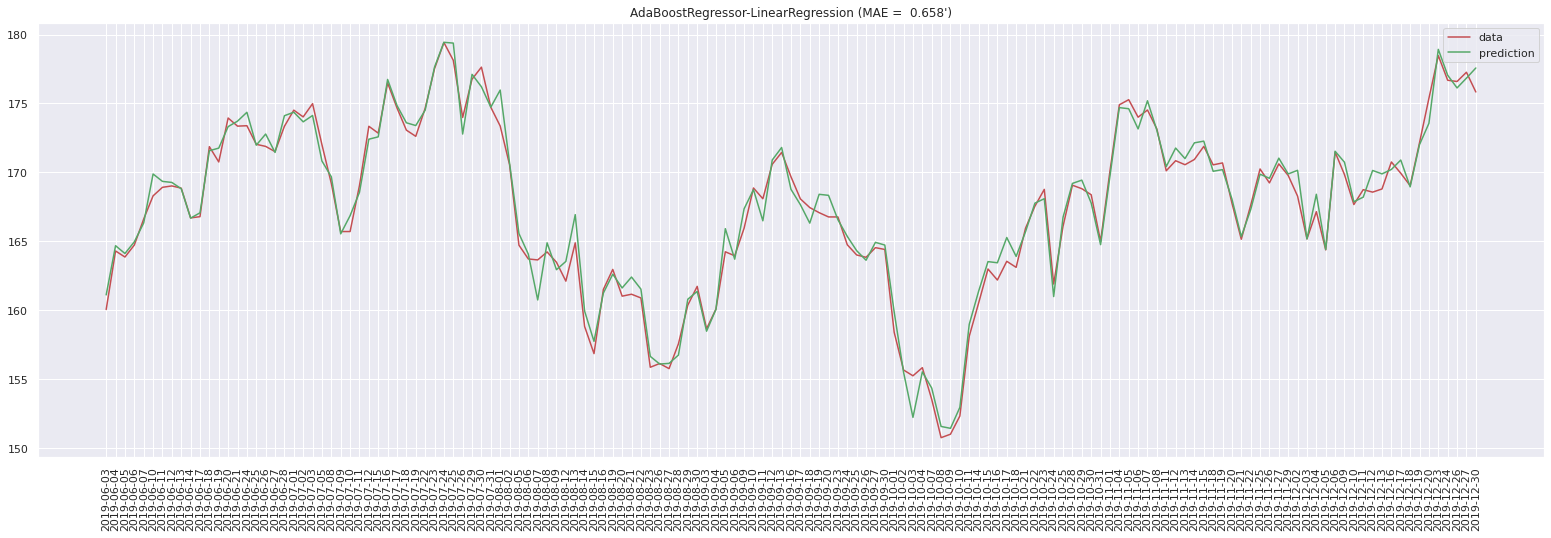

In [0]:
# Selecciono los ultimos 6 meses
test_since_June = test.loc['2019-06-01':]
y_pred_since_June = y_pred[-test_since_June.shape[0]:]

# x axis for plotting
plotdata(test_since_June,y_pred_since_June,"AdaBoostRegressor-LinearRegression",mae)

# Ensemble learning

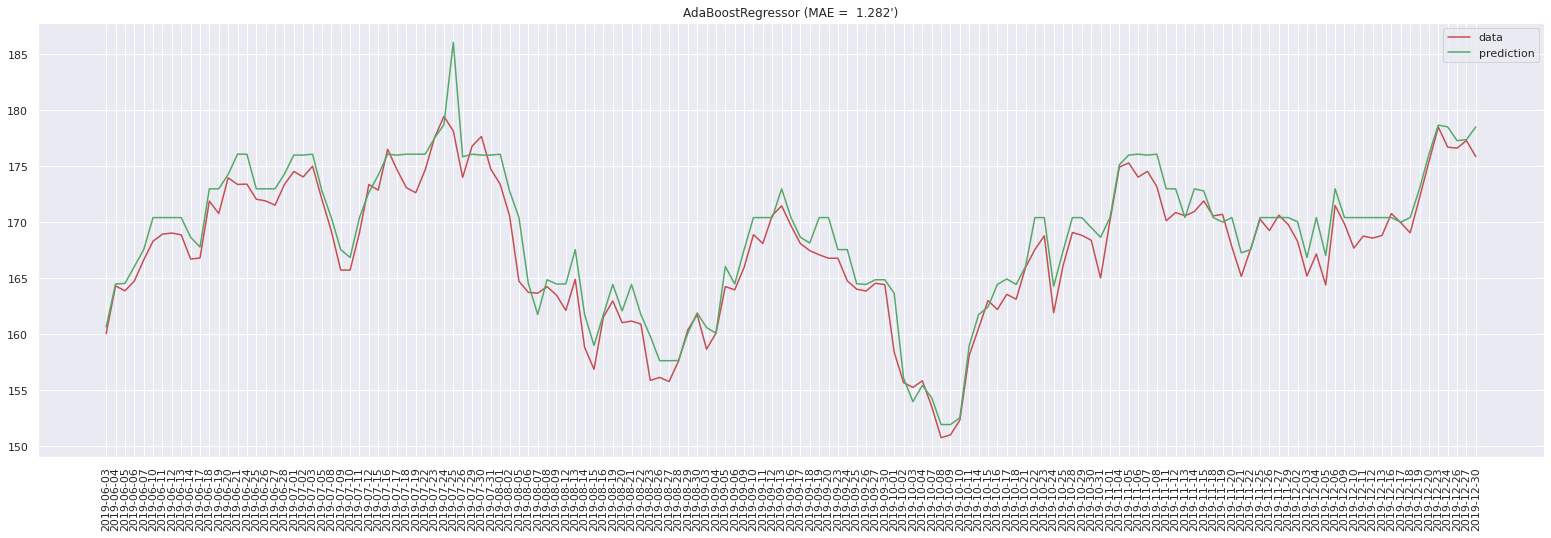

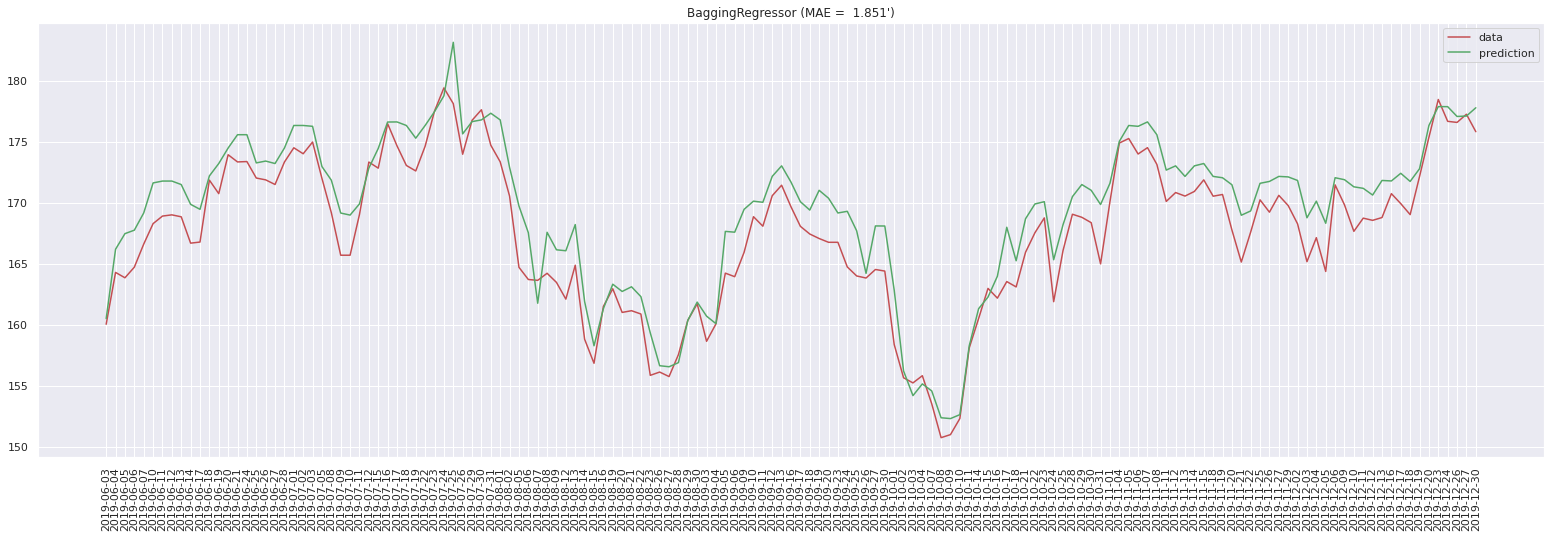

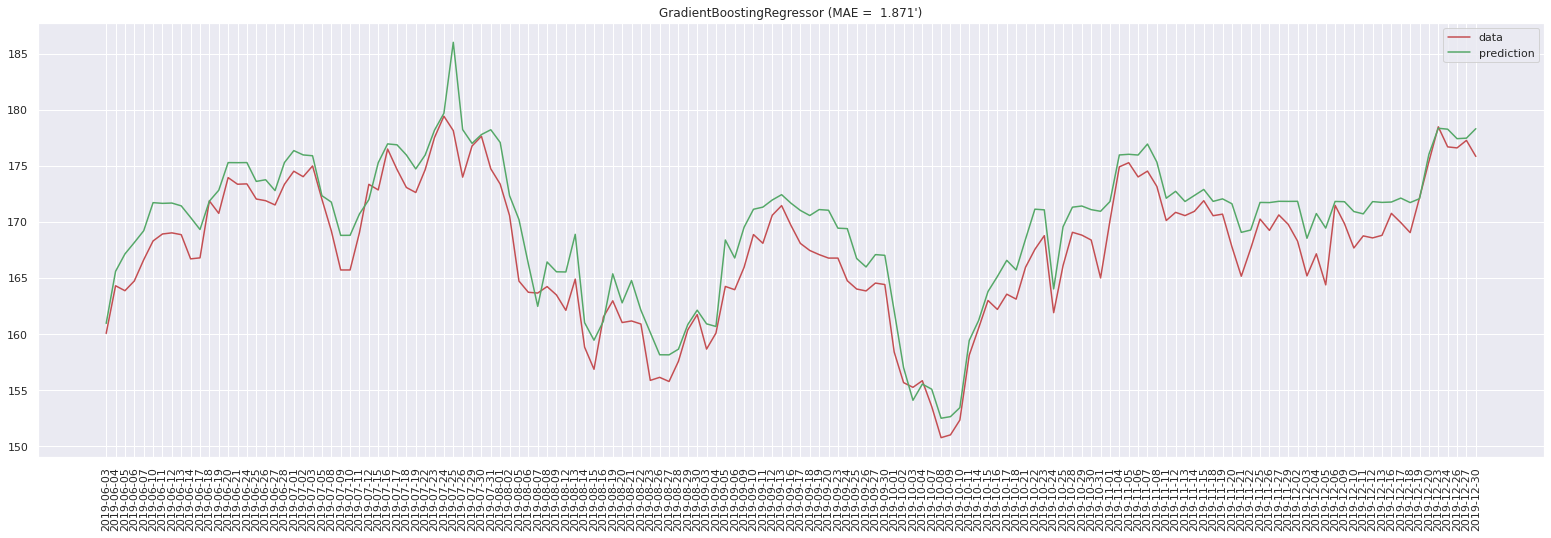

In [0]:
regressors = []

regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=8, criterion='mae'),
                                    n_estimators=10, random_state=0))

regressors.append(BaggingRegressor(DecisionTreeRegressor(max_depth=8, criterion='mae'),
                                    n_estimators=10, random_state=8))

regressors.append(GradientBoostingRegressor(max_depth=8, n_estimators=500, learning_rate=0.05, loss='ls',
                                            random_state=0))


regr_names = ["AdaBoostRegressor", 
              "BaggingRegressor", 
              "GradientBoostingRegressor"
              ]

plotModels(regressors, regr_names)

# Support Vector Machine

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


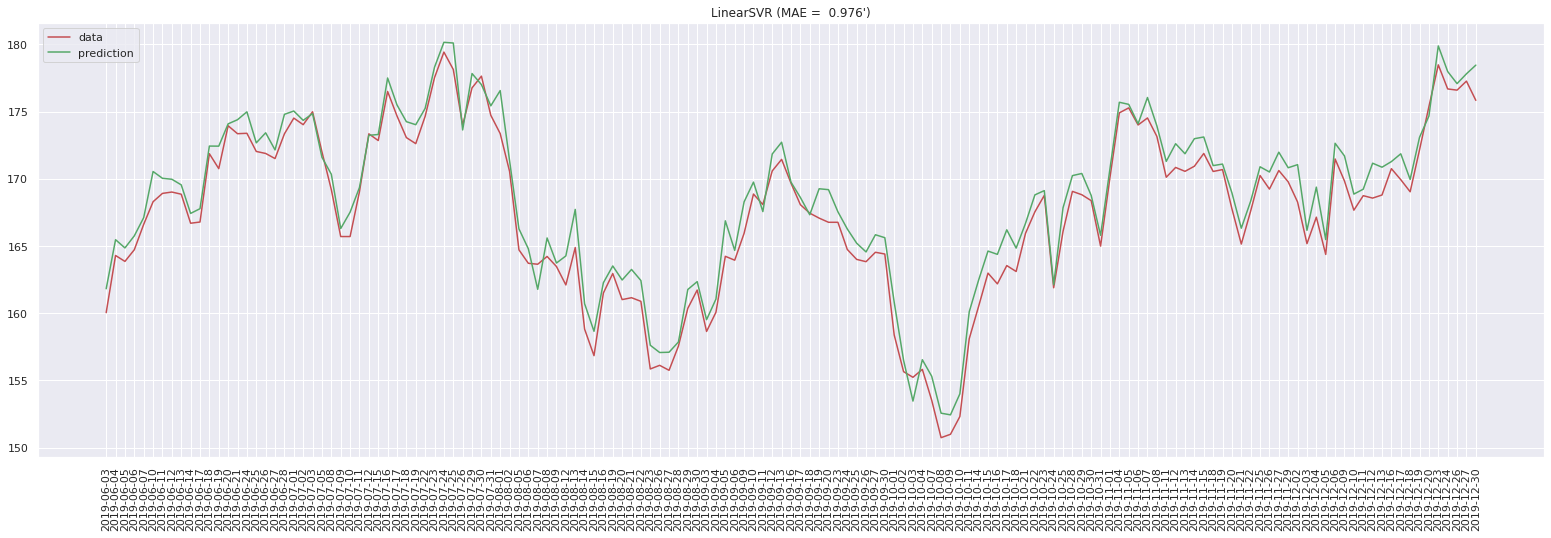

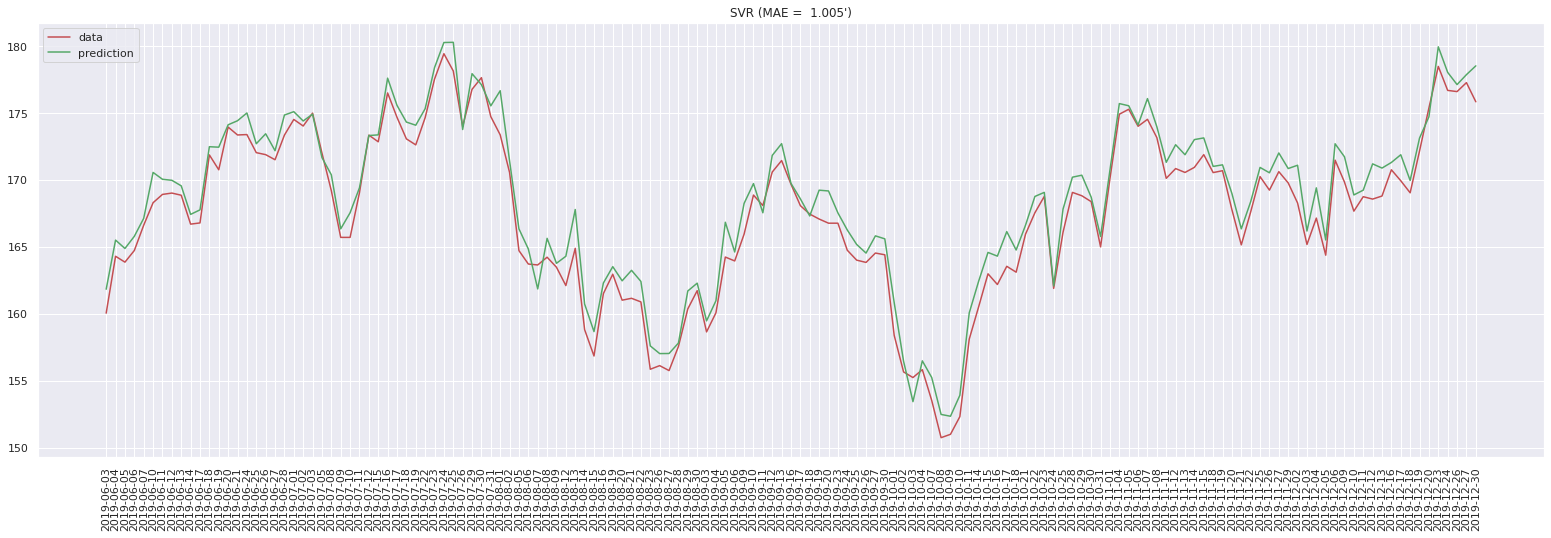

In [0]:
regressors = []

regressors.append(make_pipeline(StandardScaler(), LinearSVR(C=100, loss='epsilon_insensitive')))
regressors.append(make_pipeline(StandardScaler(), SVR(kernel='linear', C=100, gamma=0.1)))

regr_names = ["LinearSVR",
              "SVR"
              ]

plotModels(regressors, regr_names)

# Linear model

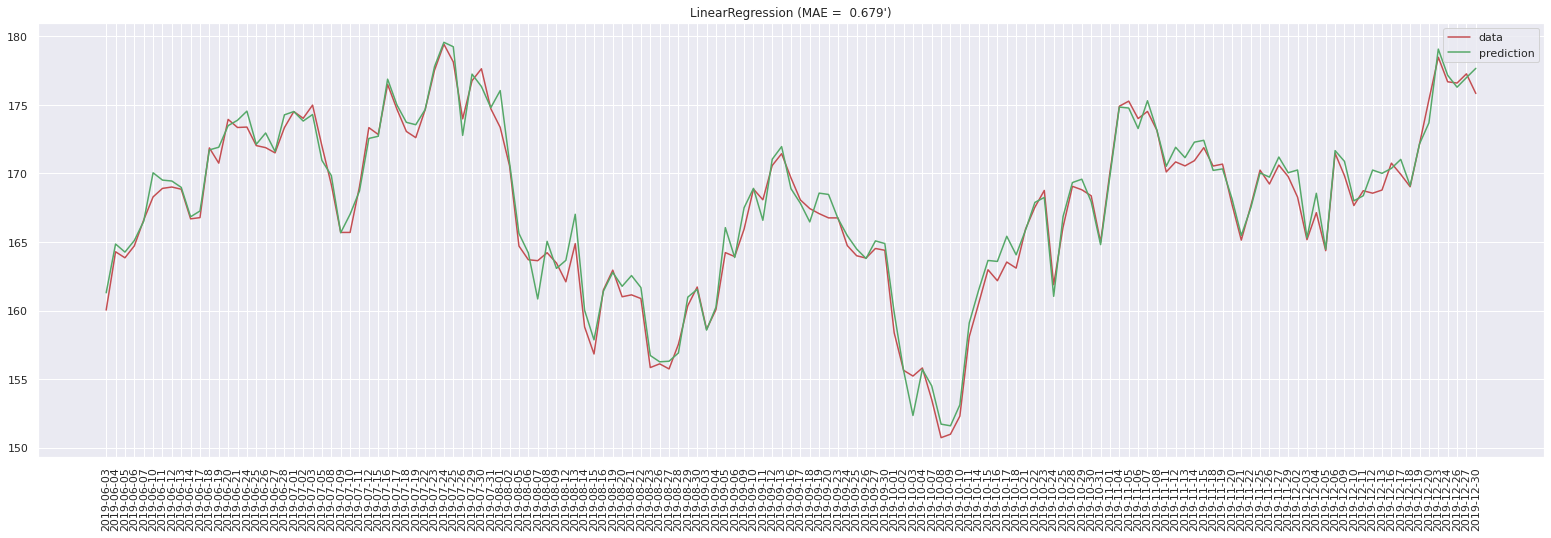

In [0]:
regressors = []

regressors.append(LinearRegression(fit_intercept=False))

regr_names = ["LinearRegression"]

plotModels(regressors, regr_names)